In [1]:
from fastai import *
from fastai.vision import *
import fastai
import time
import os
# import cv2
import matplotlib.pyplot as plt

In [2]:
IMG_PATH = '../data/VideoPOC/Imgs'

In [3]:
learner = load_learner(IMG_PATH, file='xiris_fastai_v1_097_acc.pkl')

C:\Users\njovanovic\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\njovanovic\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.AdaptiveConcatPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\njovanovic\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'fastai.layers.Flatten' has changed.

### Classify a single image from disk

In [37]:
%ls $IMG_PATH


The system cannot find the file specified.


In [27]:
# Load with open_image
test_img = open_image(IMG_PATH + '/valid/Clean/C12_12.jpg')
#test_img = open_image(IMG_PATH + '/valid/Dirty/D6_16.jpg')

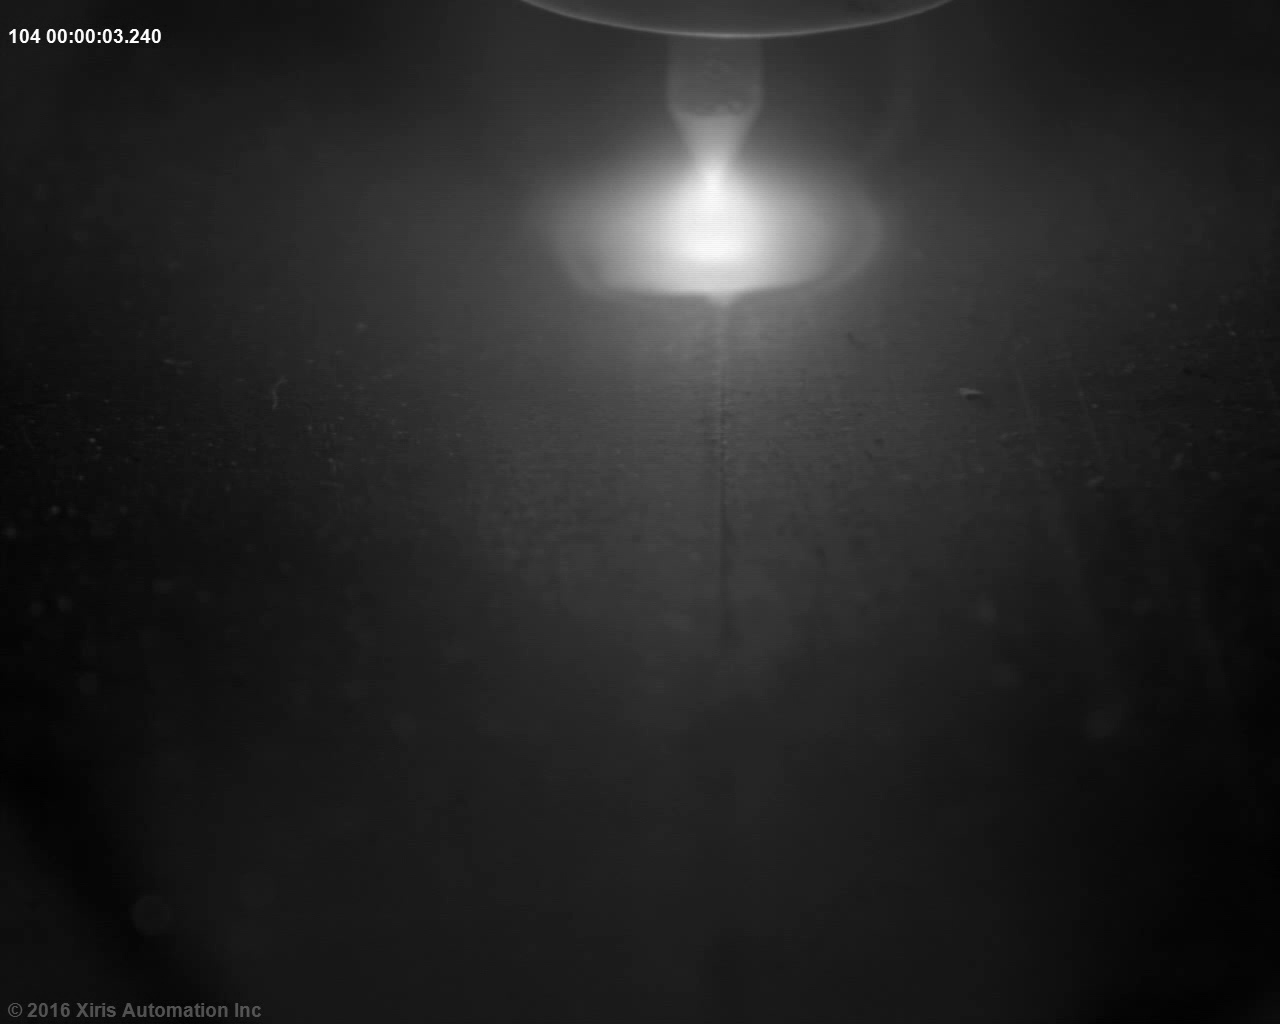

In [28]:
test_img

In [29]:
p = learner.predict(test_img)

In [30]:
p

(Category Clean, tensor(0), tensor([9.9953e-01, 4.7268e-04]))

In [51]:
# Take the tensor and compare to actual
int(p[1]) == 0

True

In [52]:
learner.data.classes

['Clean', 'Dirty']

### Classify multiple images from disk

I *believe* open image handles all the transformations and things like that. Test how many the learner is getting right to confirm. Should be the same as the confusion matrix in test_trained_model.ipynb

In [68]:
#IMG_PATH = '..\data\VideoPOC\Imgs\valid\Clean'
#IMG_PATH = "/data/VideoPOC/Imgs/valid/Clean"
IMG_PATH = "../data/VideoPOC/Imgs"


In [69]:
%ls IMG_PATH

 Volume in drive D is Data
 Volume Serial Number is E87A-179C

 Directory of d:\ML\TorchTip\POC_fai_v1



File Not Found


In [83]:
val_clean_img_dir = IMG_PATH + "/valid/Clean/"
val_dirty_img_dir = IMG_PATH + '/valid/Dirty/'
#val_clean_imgs = !ls $val_clean_img_dir
#val_dirty_imgs = !ls $val_dirty_img_dir
val_clean_imgs = os.listdir(val_clean_img_dir)
val_dirty_imgs = os.listdir(val_dirty_img_dir)

In [84]:
clean = val_clean_imgs#[:10]
dirt = val_dirty_imgs#[:100]

In [85]:
def classifyImgs(model, src_dir, img_names, true_class):
    start = time.time()
    cnt, cor, incor = 0, 0, 0
    for v in img_names:
        cnt += 1
        img = open_image(src_dir + v)
        
        pred = model.predict(img)
        
        pred_class = int(pred[1])
        if pred_class == true_class:
            cor += 1
        else:
            incor += 1
            
        if cnt % 50 == 0:
            print(f'Classified {cnt} images')
            
    print(f'Processed {cnt} images in {time.time() - start:.2f} sec using {defaults.device} device')
    return cor, incor

In [89]:
res = classifyImgs(learner, val_clean_img_dir, clean, 0)
print(f'Clean image classifications: {res[0]} correct, {res[1]} incorrect')

Classified 50 images
Classified 100 images
Classified 150 images
Classified 200 images
Processed 243 images in 84.44 sec using cuda device
Clean image classifications: 232 correct, 11 incorrect


In [90]:
res = classifyImgs(learner, val_dirty_img_dir, dirt, 1)
print(f'Dirty image classifications: {res[0]} correct, {res[1]} incorrect')

Classified 50 images
Classified 100 images
Classified 150 images
Classified 200 images
Classified 250 images
Classified 300 images
Processed 317 images in 110.17 sec using cuda device
Dirty image classifications: 314 correct, 3 incorrect


Great, this is exactly in line with my confusion matrix in test_trained_models.ipynb

### Classify images captured from a video on hard drive

This is important because I'm not using the fastai open image function. I can't do that because in practice I won't be opening an image from a hard drive. I'll be grabbing an image from a video and processing that.  

Here we start off by always grabbing the next frame

In [5]:
clean_val_vid_dir = '../data/VideoPOC/Vids/valid/Clean/'
dirty_val_vid_dir = '../data/VideoPOC/Vids/valid/Dirty/'
clean_vid_name = 'C17.avi'
dirty_vid_name = 'D15.avi'
desired_fps = 1

In [110]:
def classifyVidFrames(model, vid_dir, vid_name, num_frames, true_class):
    start = time.time()
    cap = cv2.VideoCapture(vid_dir + vid_name)
    cor, incor = 0, 0
    cntr = 0

    while(1):
        cntr += 1
        ret, frame = cap.read()
        
        if frame.ndim==3:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fr = np.expand_dims(frame,0)

        fr = torch.from_numpy(fr.astype(np.float32, copy=False) )
        fr.div_(255)
        fai_img = Image(fr)
        
        pred = model.predict(fai_img)
        
        pred_class = int(pred[1])
        if pred_class == true_class:
            cor += 1
        else:
            incor += 1
        
        if cntr % 50 == 0:
            print(f'Processed {cntr} frames')
        
        if not ret or cntr >= num_frames:
            break

    cap.release()
    print(f'Processed {num_frames} frames in {time.time() - start:.2f} sec using {defaults.device} device')
    return cor, incor

In [111]:
res = classifyVidFrames(learner, clean_val_vid_dir, clean_vid_name, 50, 0)
print(f'Clean image classifications: {res[0]} correct, {res[1]} incorrect')

Processed 50 frames
Processed 100 frames
Processed 100 frames in 89.71 sec using cpu device
Clean image classifications: 98 correct, 2 incorrect


In [116]:
res = classifyVidFrames(learner, dirty_val_vid_dir, 'D15.avi', 50, 1)
print(f'Dirty image classifications: {res[0]} correct, {res[1]} incorrect')

Processed 50 frames
Processed 50 frames in 50.03 sec using cpu device
Dirty image classifications: 50 correct, 0 incorrect


Alright we have a bit of a problem. I'm not classifying the dirty video very well. I need to dig into what part of Image_Open I'm missing. I really thought I got it all before, but I guess not!  

It might be because the start of the videos are not included in training. That's where the weld hasn't begun yet. Look into this

In [113]:
def classifyVidFrames_FPS(model, vid_dir, vid_name, true_class, fps):
    start = time.time()
    cap = cv2.VideoCapture(vid_dir + vid_name)
    cor, incor = 0, 0
    cntr = 0
    
    frame_rate = cap.get(cv2.CAP_PROP_FPS) # frame rate of this video
    frame_freq = int(frame_rate / fps)

    while cap.isOpened():
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        
        if not ret:
            break
        
        
        if (frameId % frame_freq == 0):
            cntr += 1
            
            if frame.ndim==3:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            fr = np.expand_dims(frame,0)

            fr = torch.from_numpy(fr.astype(np.float32, copy=False) )
            fr.div_(255)
            fai_img = Image(fr)
            
            pred = model.predict(fai_img)

            pred_class = int(pred[1])
            if pred_class == true_class:
                cor += 1
            else:
                incor += 1

    cap.release()
    print(f'Processed {cntr} frames in {time.time() - start:.2f} sec using {defaults.device} device')
    print(f'{cor} correct, {incor} incorrect')
    return cor, incor

In [114]:
res = classifyVidFrames_FPS(learner, clean_val_vid_dir, clean_vid_name, 0, 1)


Processed 31 frames in 32.82 sec using cpu device
31 correct, 0 incorrect


In [115]:
classifyVidFrames_FPS(learner, dirty_val_vid_dir, dirty_vid_name, 1, 1)

Processed 26 frames in 29.35 sec using cpu device
24 correct, 2 incorrect


(24, 2)

### Experiments to figure out why it wasn't working

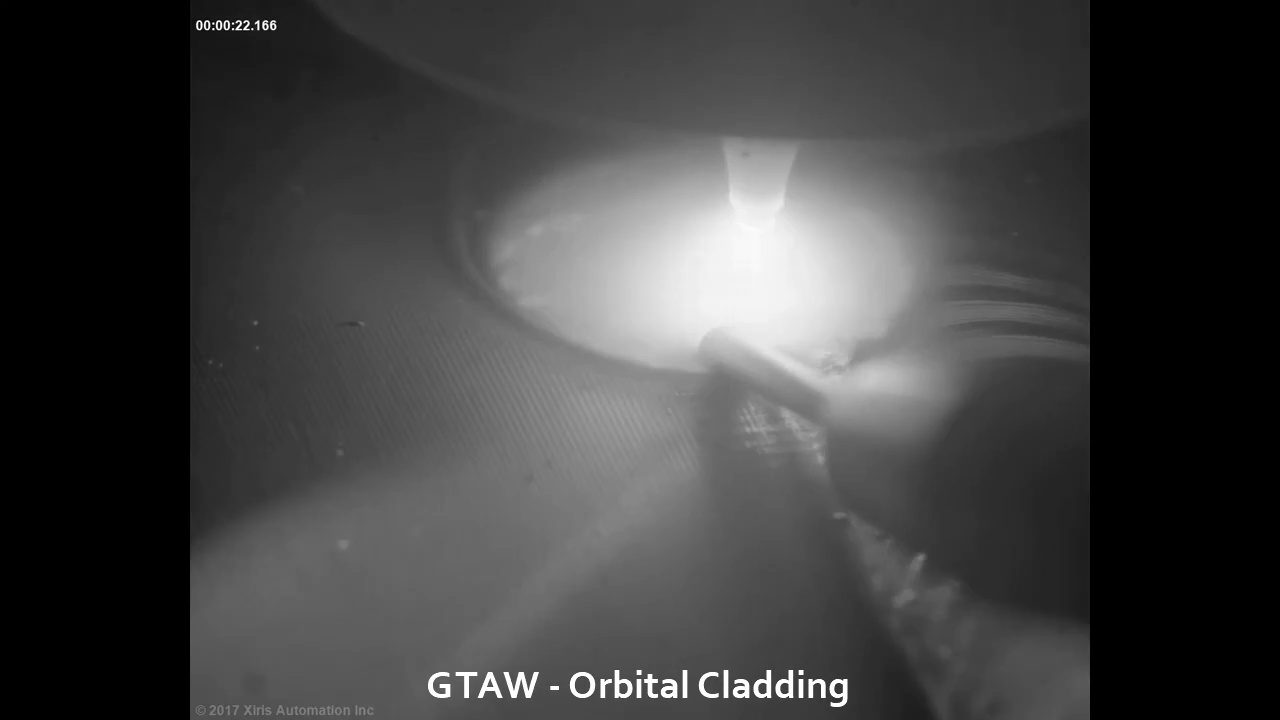

In [110]:
test_img = open_image(IMG_PATH + '/valid/Dirty/D6_38.jpg')
test_img

In [111]:
test_img.shape

torch.Size([3, 720, 1280])

In [112]:
learner.predict(test_img)

(Category Dirty, tensor(1), tensor([4.6380e-04, 9.9954e-01]))

In [49]:
# Second test: using PIL

In [116]:
pil_img = PIL.Image.open(IMG_PATH + '/valid/Dirty/D6_38.jpg').convert('RGB')

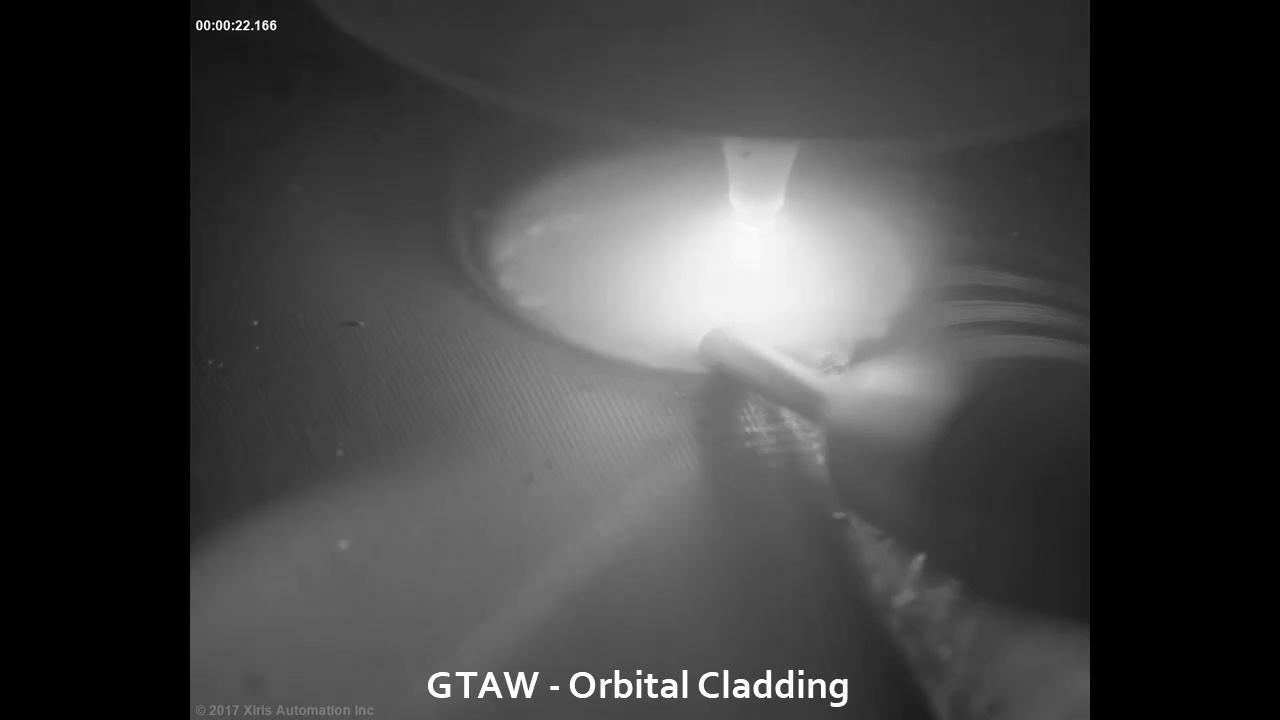

In [117]:
pil_img

In [129]:
a.shape

(720, 1280, 3)

In [130]:
# a = np.transpose(a, (1, 0, 2))
a = np.transpose(a, (2, 0, 1))
a = torch.from_numpy(a.astype(np.float32, copy=False) )

In [132]:
a.div_(255)
ai = Image(a)

In [133]:
learner.predict(ai)

(Category Dirty, tensor(1), tensor([4.6380e-04, 9.9954e-01]))

In [108]:
img_tens = pil2tensor(pil_img, np.float32)
img_tens.div_(255)
fai_img = Image(img_tens)

In [121]:
fai_img.shape

torch.Size([3, 720, 1280])

In [109]:
learner.predict(fai_img)

(Category Dirty, tensor(1), tensor([4.6380e-04, 9.9954e-01]))

Seems to be the exact same. Maybe the problem is the video?

#### Attempting to use image capture. First frame of the video

In [89]:
cap = cv2.VideoCapture('../data/VideoPOC/Vids/valid/Dirty/D15.avi')
ret, frame = cap.read()
cap.release()    

In [90]:
frame.shape

(1024, 1280, 3)

In [77]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame.shape

(1024, 1280)

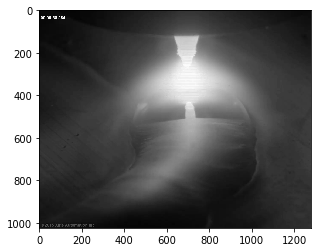

In [79]:
imgplot = plt.imshow(frame, cmap='gray')

In [91]:
# fr = np.transpose(frame, (2, 0, 1))
if frame.ndim==3:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
fr = np.expand_dims(frame,0)
# else:
#     fr = np.transpose(fr, (2, 0, 1))
fr = torch.from_numpy(fr.astype(np.float32, copy=False) )
fr.div_(255)
fr = Image(fr)

In [92]:
fr.shape

torch.Size([1, 1024, 1280])

In [93]:
learner.predict(fr)

(Category Dirty, tensor(1), tensor([4.8183e-04, 9.9952e-01]))

#### Fastai's open image - gets a different prediction but it's the exact same frame

In [32]:
ff=open_image(IMG_PATH + '/valid/Dirty/D15_1.jpg')

In [33]:
ff.shape

torch.Size([3, 1024, 1280])

In [34]:
learner.predict(ff)

(Category Dirty, tensor(1), tensor([6.3600e-04, 9.9936e-01]))

#### pil imread - same as open_image? Yes it sure is

In [58]:
cc = PIL.Image.open(IMG_PATH + '/valid/Dirty/D15_1.jpg').convert('RGB')
cc = np.transpose(cc, (1, 0, 2))
cc = np.transpose(cc, (2, 1, 0))
cc = torch.from_numpy(cc.astype(np.float32, copy=False) )
cc.div_(255)
cc = Image(cc)

In [59]:
learner.predict(cc)

(Category Dirty, tensor(1), tensor([3.1594e-04, 9.9968e-01]))

#### Open CV - same as open_image? why yes it is!

In [62]:
oo = cv2.imread(IMG_PATH + '/valid/Dirty/D15_1.jpg')
oo = np.transpose(oo, (1, 0, 2))
oo = np.transpose(oo, (2, 1, 0))
oo = torch.from_numpy(oo.astype(np.float32, copy=False) )
oo.div_(255)
oo = Image(oo)

In [63]:
learner.predict(oo)

(Category Dirty, tensor(1), tensor([3.1594e-04, 9.9968e-01]))

#### Compare the actual captured image to what's read in

In [65]:
cap = cv2.VideoCapture('../data/VideoPOC/Vids/valid/Dirty/D15.avi')
ret, capframe = cap.read()
cap.release() 

In [66]:
loadframe = cv2.imread(IMG_PATH + '/valid/Dirty/D15_1.jpg')

In [68]:
capframe.shape, loadframe.shape

((1024, 1280, 3), (1024, 1280, 3))

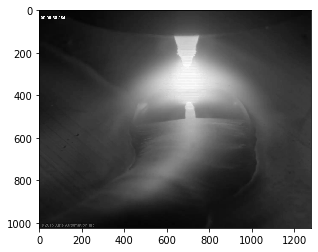

In [75]:
cf = cv2.cvtColor(capframe, cv2.COLOR_RGB2GRAY)

plt.imshow(cf, cmap='gray')

Only thing I've been able to see is that these values are different. Just checked and the image is the exact same. Exact - same timestamp on the video and everything. Something is going on here for sure

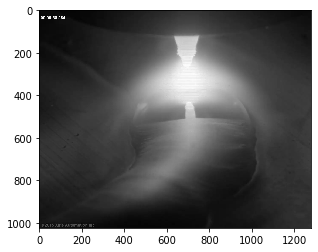

In [71]:
plt.imshow(loadframe)

The lighting is definitely different here! Figured it out!! It was a 3-channel problem. We should be all good now

One remaining question. I'm training the model on a 3-channel image with 3 identical channels. Here I'm converting to a 1 channel image. I don't know if there's a difference there

In [80]:
??open_image

In [81]:
??pil2tensor